## Predicting COVID-19 cases using ML

This notebook looks into various data science and ML models to predict the number of positive cases in each state on a particular after taking in account the total number of samples tested.


In [1]:
# Importing all the tools we need

# Regular EDA(Exploratory Data Analysis) and plotting libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# We want all our plots to appear inside the notebook
%matplotlib inline

# Models from Sci-Kit learn(Imported later)
from sklearn.linear_model import LogisticRegression

# Model Evaluation(Imported later)
from sklearn.model_selection import train_test_split, cross_val_score

In [2]:
df=pd.read_csv('StatewiseTestingDetails.csv')

In [3]:
df.head()

,Date,State,TotalSamples,Negative,Positive
0,4/17/2020,Andaman and Nicobar Islands,1403,1210,12.0
1,4/24/2020,Andaman and Nicobar Islands,2679,NaN,27.0
2,4/27/2020,Andaman and Nicobar Islands,2848,NaN,33.0
3,5/1/2020,Andaman and Nicobar Islands,3754,NaN,33.0
4,5/16/2020,Andaman and Nicobar Islands,6677,NaN,33.0


In [4]:
df.shape

(13403, 5)

In [5]:
 ## Check missing or null values

In [6]:
df.isnull().sum()

Date               0
State              0
TotalSamples       0
Negative        7273
Positive        7959
dtype: int64

In [7]:
df.describe()

,TotalSamples,Positive
count,1.340300e+04,5.444000e+03
mean,3.788835e+06,5.237404e+04
std,6.129422e+06,1.647659e+05
min,5.800000e+01,0.000000e+00
25%,1.151665e+05,4.897500e+02
50%,6.116090e+05,4.196500e+03
75%,5.410430e+06,3.303500e+04
max,4.523109e+07,1.638961e+06


In [8]:
df.Date.dtype

dtype('O')

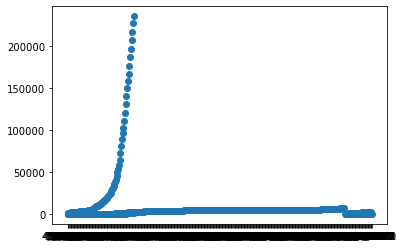

In [9]:
fig,ax = plt.subplots()
ax.scatter(df["Date"][:1000],df["Positive"][:1000])

<AxesSubplot:ylabel='Frequency'>

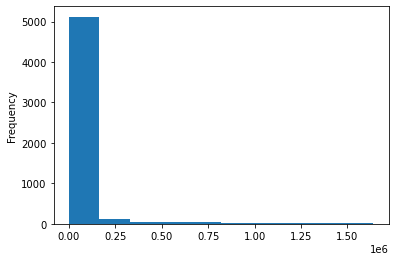

In [10]:
df.Positive.plot.hist()

### Parsing dates

When we work with time series data, we want to enrich the time and date componenet as much as possible.

We can do that by telling pandas which of our columns has dates in it using the `parse_dates` parameter

In [11]:
df=pd.read_csv('StatewiseTestingDetails.csv',low_memory=False,
               parse_dates=["Date"])

In [12]:
df.Date.dtype

dtype('<M8[ns]')

In [13]:
df.Date[:1000]

0     2020-04-17
1     2020-04-24
2     2020-04-27
3     2020-05-01
4     2020-05-16
         ...    
995   2020-11-29
996   2020-11-30
997   2020-12-01
998   2020-12-02
999   2020-12-03
Name: Date, Length: 1000, dtype: datetime64[ns]

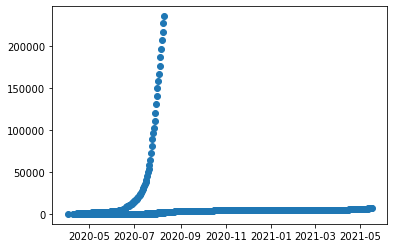

In [14]:
fig,ax = plt.subplots()
ax.scatter(df["Date"][:1000],df["Positive"][:1000])

### Sort DataFrame by Date

When working with time series data,it's a good idea to sort it by date.

In [15]:
df.sort_values(by=["Date"],inplace=True,ascending=True)
df.Date.head(20)

2920    2020-04-01
12994   2020-04-01
6151    2020-04-01
6152    2020-04-02
9933    2020-04-02
3325    2020-04-02
2352    2020-04-02
1956    2020-04-02
369     2020-04-02
1166    2020-04-02
12587   2020-04-02
11076   2020-04-03
4127    2020-04-03
9131    2020-04-03
5744    2020-04-03
6153    2020-04-03
6154    2020-04-04
12995   2020-04-04
12181   2020-04-05
12182   2020-04-05
Name: Date, dtype: datetime64[ns]

In [180]:
df.pop("Negative")

2920          NaN
12994         568
6151         7256
6152         7622
9933          NaN
           ...   
772      16664935
9932       825199
6563          NaN
4534          NaN
13402         NaN
Name: Negative, Length: 13403, dtype: object

In [185]:
df = df.dropna()

In [186]:
df.State.unique()

array(['West Bengal', 'Kerala', 'Punjab', 'Goa', 'Chhattisgarh',
       'Chandigarh', 'Andhra Pradesh', 'Assam', 'Uttarakhand',
       'Tamil Nadu', 'Haryana', 'Odisha', 'Karnataka', 'Uttar Pradesh',
       'Jammu and Kashmir', 'Bihar', 'Madhya Pradesh', 'Nagaland',
       'Maharashtra', 'Mizoram', 'Delhi', 'Rajasthan', 'Gujarat',
       'Arunachal Pradesh', 'Dadra and Nagar Haveli and Daman and Diu',
       'Himachal Pradesh', 'Jharkhand', 'Tripura', 'Ladakh', 'Manipur',
       'Meghalaya', 'Andaman and Nicobar Islands', 'Puducherry',
       'Telangana', 'Sikkim'], dtype=object)

### Make a copy of original Dataframe

We make a copy so when we manipulate we still got original data.

In [16]:
# Make a copy
df_tmp=df.copy()

In [17]:
df_tmp.Date.head(20)

2920    2020-04-01
12994   2020-04-01
6151    2020-04-01
6152    2020-04-02
9933    2020-04-02
3325    2020-04-02
2352    2020-04-02
1956    2020-04-02
369     2020-04-02
1166    2020-04-02
12587   2020-04-02
11076   2020-04-03
4127    2020-04-03
9131    2020-04-03
5744    2020-04-03
6153    2020-04-03
6154    2020-04-04
12995   2020-04-04
12181   2020-04-05
12182   2020-04-05
Name: Date, dtype: datetime64[ns]

### Add datetime parameters for Date column

In [18]:
df_tmp["Year"]=df_tmp.Date.dt.year
df_tmp["Month"]=df_tmp.Date.dt.month
df_tmp["Day"]=df_tmp.Date.dt.day
df_tmp["DayOfWeek"]=df_tmp.Date.dt.dayofweek
df_tmp["DayOfYear"]=df_tmp.Date.dt.dayofyear

In [19]:
df_tmp.head().T

,2920,12994,6151,6152,9933
Date,2020-04-01 00:00:00,2020-04-01 00:00:00,2020-04-01 00:00:00,2020-04-02 00:00:00,2020-04-02 00:00:00
State,Delhi,West Bengal,Kerala,Kerala,Punjab
TotalSamples,2621,659,7965,8456,1434
Negative,NaN,568,7256,7622,NaN
Positive,NaN,37.0,265.0,286.0,37.0
Year,2020,2020,2020,2020,2020
Month,4,4,4,4,4
Day,1,1,1,2,2
DayOfWeek,2,2,2,3,3
DayOfYear,92,92,92,93,93


In [20]:
df_tmp.drop("Date",axis=1,inplace=True)

In [21]:
df_tmp.head().T

,2920,12994,6151,6152,9933
State,Delhi,West Bengal,Kerala,Kerala,Punjab
TotalSamples,2621,659,7965,8456,1434
Negative,NaN,568,7256,7622,NaN
Positive,NaN,37.0,265.0,286.0,37.0
Year,2020,2020,2020,2020,2020
Month,4,4,4,4,4
Day,1,1,1,2,2
DayOfWeek,2,2,2,3,3
DayOfYear,92,92,92,93,93


In [22]:
df_tmp.State.value_counts()

Kerala                                      413
West Bengal                                 409
Haryana                                     408
Odisha                                      408
Madhya Pradesh                              408
Punjab                                      407
Uttarakhand                                 407
Tamil Nadu                                  407
Rajasthan                                   407
Karnataka                                   407
Uttar Pradesh                               406
Delhi                                       405
Bihar                                       405
Jammu and Kashmir                           405
Maharashtra                                 404
Himachal Pradesh                            404
Andhra Pradesh                              404
Gujarat                                     403
Nagaland                                    400
Jharkhand                                   400
Goa                                     

In [23]:
df_tmp.isna().sum()

State              0
TotalSamples       0
Negative        7273
Positive        7959
Year               0
Month              0
Day                0
DayOfWeek          0
DayOfYear          0
dtype: int64

### Convert String to Categories

One way we can turn all of our data into numbers is by converting them into pandas categories.


In [24]:
df_tmp.head().T

,2920,12994,6151,6152,9933
State,Delhi,West Bengal,Kerala,Kerala,Punjab
TotalSamples,2621,659,7965,8456,1434
Negative,NaN,568,7256,7622,NaN
Positive,NaN,37.0,265.0,286.0,37.0
Year,2020,2020,2020,2020,2020
Month,4,4,4,4,4
Day,1,1,1,2,2
DayOfWeek,2,2,2,3,3
DayOfYear,92,92,92,93,93


In [25]:
pd.api.types.is_string_dtype(df_tmp["State"])

True

In [26]:
# Find the columns which contain strings
for label,content in df_tmp.items():
    if pd.api.types.is_string_dtype(content):
        print(label)

State
Negative


In [27]:
df.Negative.dtype

dtype('O')

In [28]:
# This will turn all of the string values into category values
for label,content in df_tmp.items():
    if pd.api.types.is_string_dtype(content):
        df_tmp[label]=content.astype("category").cat.as_ordered()

In [29]:
df_tmp.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 13403 entries, 2920 to 13402
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype   
---  ------        --------------  -----   
 0   State         13403 non-null  category
 1   TotalSamples  13403 non-null  int64   
 2   Negative      6130 non-null   category
 3   Positive      5444 non-null   float64 
 4   Year          13403 non-null  int64   
 5   Month         13403 non-null  int64   
 6   Day           13403 non-null  int64   
 7   DayOfWeek     13403 non-null  int64   
 8   DayOfYear     13403 non-null  int64   
dtypes: category(2), float64(1), int64(6)
memory usage: 1.0 MB


In [30]:
df_tmp.State.cat.categories

Index(['Andaman and Nicobar Islands', 'Andhra Pradesh', 'Arunachal Pradesh',
       'Assam', 'Bihar', 'Chandigarh', 'Chhattisgarh',
       'Dadra and Nagar Haveli and Daman and Diu', 'Delhi', 'Goa', 'Gujarat',
       'Haryana', 'Himachal Pradesh', 'Jammu and Kashmir', 'Jharkhand',
       'Karnataka', 'Kerala', 'Ladakh', 'Lakshadweep', 'Madhya Pradesh',
       'Maharashtra', 'Manipur', 'Meghalaya', 'Mizoram', 'Nagaland', 'Odisha',
       'Puducherry', 'Punjab', 'Rajasthan', 'Sikkim', 'Tamil Nadu',
       'Telangana', 'Tripura', 'Uttar Pradesh', 'Uttarakhand', 'West Bengal'],
      dtype='object')

In [31]:
df_tmp.State.cat.codes

2920      8
12994    35
6151     16
6152     16
9933     27
         ..
772       1
9932     26
6563     16
4534     11
13402    35
Length: 13403, dtype: int8

# Save preprocessed data

In [32]:
# Export current tmp dataframe
df_tmp.to_csv("case-prediction-tmp.csv",index=False)

In [33]:
# Import preprocessed data
df_tmp=pd.read_csv("case-prediction-tmp.csv",low_memory=False)

In [34]:
df_tmp.head().T

,0,1,2,3,4
State,Delhi,West Bengal,Kerala,Kerala,Punjab
TotalSamples,2621,659,7965,8456,1434
Negative,NaN,568,7256,7622,NaN
Positive,NaN,37.0,265.0,286.0,37.0
Year,2020,2020,2020,2020,2020
Month,4,4,4,4,4
Day,1,1,1,2,2
DayOfWeek,2,2,2,3,3
DayOfYear,92,92,92,93,93


###  Fill missing values

#### Fill numeric missing values first

In [35]:
for label,content in df_tmp.items():
    if pd.api.types.is_numeric_dtype(content):
        print(label)
    

TotalSamples
Positive
Year
Month
Day
DayOfWeek
DayOfYear


In [36]:
# Check for which numeric columns have null values
for label,content in df_tmp.items():
    if pd.api.types.is_numeric_dtype(content):
        if pd.isnull(content).sum():
            print(label)

Positive


In [37]:
# Fill numeric rows with the median
for label,content in df_tmp.items():
    if pd.api.types.is_numeric_dtype(content):
        if pd.isnull(content).sum():
            # Fill missing values with mean
            df_tmp[label]=content.fillna(content.median())

In [52]:
# Demonstrate how median is more robust than mean
hundreds=np.full((100,),100)
hundreds_billion=np.append(hundreds,100000000)
np.mean(hundreds),np.mean(hundreds_billion),np.median(hundreds),np.median(hundreds_billion)

(100.0, 990198.0198019802, 100.0, 100.0)

In [53]:
hundreds_billion

array([      100,       100,       100,       100,       100,       100,
             100,       100,       100,       100,       100,       100,
             100,       100,       100,       100,       100,       100,
             100,       100,       100,       100,       100,       100,
             100,       100,       100,       100,       100,       100,
             100,       100,       100,       100,       100,       100,
             100,       100,       100,       100,       100,       100,
             100,       100,       100,       100,       100,       100,
             100,       100,       100,       100,       100,       100,
             100,       100,       100,       100,       100,       100,
             100,       100,       100,       100,       100,       100,
             100,       100,       100,       100,       100,       100,
             100,       100,       100,       100,       100,       100,
             100,       100,       100,       100, 

In [38]:
# Check if there is any null numeric values
for label,content in df_tmp.items():
    if pd.api.types.is_numeric_dtype(content):
        if pd.isnull(content).sum():
            print(label)

In [39]:
df_tmp.isna().sum()

State              0
TotalSamples       0
Negative        7273
Positive           0
Year               0
Month              0
Day                0
DayOfWeek          0
DayOfYear          0
dtype: int64

In [40]:
df_tmp.head().T

,0,1,2,3,4
State,Delhi,West Bengal,Kerala,Kerala,Punjab
TotalSamples,2621,659,7965,8456,1434
Negative,NaN,568,7256,7622,NaN
Positive,4196.5,37.0,265.0,286.0,37.0
Year,2020,2020,2020,2020,2020
Month,4,4,4,4,4
Day,1,1,1,2,2
DayOfWeek,2,2,2,3,3
DayOfYear,92,92,92,93,93


In [57]:
df_tmp.Positive_is_missing.value_counts()

True     7959
False    5444
Name: Positive_is_missing, dtype: int64

### Filling and turning categorical variable into numbers


In [41]:
# Check for columns which are not numeric
for label,content in df_tmp.items():
    if not pd.api.types.is_numeric_dtype(content):
        print(label)

State
Negative


In [42]:
# Turn Categorical variables into numbers and fill missing 
for label,content in df_tmp.items():
    if not pd.api.types.is_numeric_dtype(content):
        # Add a binary column to indicate whether sample had missing value
        df_tmp[label] = pd.Categorical(content).codes+1

In [43]:
pd.Categorical(df_tmp["State"]).codes+1

array([ 9, 36, 17, ..., 17, 12, 36], dtype=int8)

In [44]:
pd.Categorical(df_tmp["Negative"]).codes

array([   0, 4628, 5385, ...,    0,    0,    0], dtype=int16)

In [45]:
df_tmp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13403 entries, 0 to 13402
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   State         13403 non-null  int8   
 1   TotalSamples  13403 non-null  int64  
 2   Negative      13403 non-null  int16  
 3   Positive      13403 non-null  float64
 4   Year          13403 non-null  int64  
 5   Month         13403 non-null  int64  
 6   Day           13403 non-null  int64  
 7   DayOfWeek     13403 non-null  int64  
 8   DayOfYear     13403 non-null  int64  
dtypes: float64(1), int16(1), int64(6), int8(1)
memory usage: 772.4 KB


In [46]:
df_tmp.isna().sum()

State           0
TotalSamples    0
Negative        0
Positive        0
Year            0
Month           0
Day             0
DayOfWeek       0
DayOfYear       0
dtype: int64

In [47]:
df_tmp.head().T

,0,1,2,3,4
State,9.0,36.0,17.0,17.0,28.0
TotalSamples,2621.0,659.0,7965.0,8456.0,1434.0
Negative,0.0,4628.0,5385.0,5508.0,0.0
Positive,4196.5,37.0,265.0,286.0,37.0
Year,2020.0,2020.0,2020.0,2020.0,2020.0
Month,4.0,4.0,4.0,4.0,4.0
Day,1.0,1.0,1.0,2.0,2.0
DayOfWeek,2.0,2.0,2.0,3.0,3.0
DayOfYear,92.0,92.0,92.0,93.0,93.0


In [48]:
df_tmp.head(100)

,State,TotalSamples,Negative,Positive,Year,Month,Day,DayOfWeek,DayOfYear
0,9,2621,0,4196.5,2020,4,1,2,92
1,36,659,4628,37.0,2020,4,1,2,92
2,17,7965,5385,265.0,2020,4,1,2,92
3,17,8456,5508,286.0,2020,4,2,3,93
4,28,1434,0,37.0,2020,4,2,3,93
...,...,...,...,...,...,...,...,...,...
95,9,11061,6007,903.0,2020,4,10,4,101
96,26,3551,2896,51.0,2020,4,11,5,102
97,21,31841,2491,1761.0,2020,4,11,5,102
98,9,11709,51,1069.0,2020,4,11,5,102


In [49]:
df_tmp

,State,TotalSamples,Negative,Positive,Year,Month,Day,DayOfWeek,DayOfYear
0,9,2621,0,4196.5,2020,4,1,2,92
1,36,659,4628,37.0,2020,4,1,2,92
2,17,7965,5385,265.0,2020,4,1,2,92
3,17,8456,5508,286.0,2020,4,2,3,93
4,28,1434,0,37.0,2020,4,2,3,93
...,...,...,...,...,...,...,...,...,...
13398,2,18140307,1091,4196.5,2021,5,18,1,138
13399,27,944147,5682,4196.5,2021,5,18,1,138
13400,17,18149395,0,4196.5,2021,5,18,1,138
13401,12,8409814,0,4196.5,2021,5,18,1,138


In [50]:
df_tmp.pop("Negative")

0           0
1        4628
2        5385
3        5508
4           0
         ... 
13398    1091
13399    5682
13400       0
13401       0
13402       0
Name: Negative, Length: 13403, dtype: int16

In [51]:
len(df_tmp)

13403

In [52]:
df_tmp

,State,TotalSamples,Positive,Year,Month,Day,DayOfWeek,DayOfYear
0,9,2621,4196.5,2020,4,1,2,92
1,36,659,37.0,2020,4,1,2,92
2,17,7965,265.0,2020,4,1,2,92
3,17,8456,286.0,2020,4,2,3,93
4,28,1434,37.0,2020,4,2,3,93
...,...,...,...,...,...,...,...,...
13398,2,18140307,4196.5,2021,5,18,1,138
13399,27,944147,4196.5,2021,5,18,1,138
13400,17,18149395,4196.5,2021,5,18,1,138
13401,12,8409814,4196.5,2021,5,18,1,138


In [53]:
len(df_tmp)

13403

In [67]:
df_tmp.drop(df_tmp[df_tmp['Positive'] == df_tmp["Positive"].median()].index, inplace = True)

In [68]:
len(df_tmp)

5444

In [99]:
df_tmp.isna().sum()

State                  0
TotalSamples           0
Positive               0
Year                   0
Month                  0
Day                    0
DayOfWeek              0
DayOfYear              0
Positive_is_missing    0
State_is_missing       0
dtype: int64

Now that all of our data is numeric as well as our datafram has no missing values,we can build a ML model

In [69]:
%%time
# Instantiate 
from sklearn.ensemble import RandomForestRegressor
model = RandomForestRegressor(n_jobs=-1,random_state=42)
model.fit(df_tmp.drop("Positive",axis=1),df_tmp["Positive"])



Wall time: 437 ms


RandomForestRegressor(n_jobs=-1, random_state=42)

In [70]:
model.score(df_tmp.drop("Positive",axis=1),df_tmp["Positive"])

0.9997894283854972

## Splitting data into train/test set

In [71]:
df_tmp.Year

1        2020
2        2020
3        2020
4        2020
5        2020
         ... 
13339    2021
13340    2021
13366    2021
13385    2021
13388    2021
Name: Year, Length: 5444, dtype: int64

In [72]:
# Split data into X & y
X=df_tmp.drop("Positive",axis=1)
y=df_tmp["Positive"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [73]:
len(X_train),len(X_test)

(4355, 1089)

In [74]:
len(X_train),len(X_test)

(4355, 1089)

# Building an evaluation function

In [75]:
# RMSLE 
from sklearn.metrics import mean_squared_log_error,mean_absolute_error,r2_score
def rmsle(y_test, y_preds):
    """
    Calculates root mean squared log error between predictions and true label
    """
    return np.sqrt(mean_squared_log_error(y_test,y_preds))
def show_scores(model):
    train_preds=model.predict(X_train)
    test_preds=model.predict(X_test)
    scores={"Training MAE": mean_absolute_error(y_train ,train_preds),
            "Test MAE":mean_absolute_error(y_test,test_preds),
            "Training MSLE": rmsle(y_train, train_preds),
            "Testing MSLE":rmsle(y_test, test_preds),
            "Training R^2": r2_score(y_train, train_preds),
            "Test R^2":r2_score(y_test, test_preds)
    }
    return scores


In [76]:
model = RandomForestRegressor(n_jobs=-1,random_state=42)

In [77]:
model.fit(X_train,y_train)

RandomForestRegressor(n_jobs=-1, random_state=42)

In [78]:
show_scores(model)

{'Training MAE': 811.083928817451,
 'Test MAE': 1807.800165289256,
 'Training MSLE': 0.20544213759614835,
 'Testing MSLE': 0.3804820922567538,
 'Training R^2': 0.9996312223440971,
 'Test R^2': 0.9986144638869788}

In [79]:
from sklearn.model_selection import RandomizedSearchCV
rf_grid={"n_estimators":np.arange(10,100,10),
          "max_depth":[None,3,5,10],
          "min_samples_split":np.arange(2,20,2),
          "min_samples_leaf":np.arange(1,20,2),
          "max_features":[0.5,1,"sqrt","auto"] }
rs_model=RandomizedSearchCV(RandomForestRegressor(n_jobs=-1,
                                                random_state=42),
                           param_distributions=rf_grid,
                           n_iter=40,
                           cv=5,
                           verbose=True
                           )

rs_model.fit(X_train,y_train)
    


Fitting 5 folds for each of 40 candidates, totalling 200 fits


RandomizedSearchCV(cv=5,
                   estimator=RandomForestRegressor(n_jobs=-1, random_state=42),
                   n_iter=40,
                   param_distributions={'max_depth': [None, 3, 5, 10],
                                        'max_features': [0.5, 1, 'sqrt',
                                                         'auto'],
                                        'min_samples_leaf': array([ 1,  3,  5,  7,  9, 11, 13, 15, 17, 19]),
                                        'min_samples_split': array([ 2,  4,  6,  8, 10, 12, 14, 16, 18]),
                                        'n_estimators': array([10, 20, 30, 40, 50, 60, 70, 80, 90])},
                   verbose=True)

In [80]:
# Find the best model
rs_model.best_params_

{'n_estimators': 20,
 'min_samples_split': 8,
 'min_samples_leaf': 1,
 'max_features': 0.5,
 'max_depth': 10}

In [81]:
show_scores(rs_model)

{'Training MAE': 3794.5322103831004,
 'Test MAE': 5365.578052281298,
 'Training MSLE': 1.292574368995822,
 'Testing MSLE': 1.4294464622413383,
 'Training R^2': 0.9964084356335874,
 'Test R^2': 0.993426849514488}

In [82]:
ideal_model=RandomForestRegressor(n_jobs=-1,random_state=42,
                               n_estimators=100,
                               min_samples_leaf=1,
                               min_samples_split=2,
                               max_features='auto')
ideal_model.fit(X_train,y_train)
show_scores(ideal_model)
                           


{'Training MAE': 811.083928817451,
 'Test MAE': 1807.800165289256,
 'Training MSLE': 0.20544213759614835,
 'Testing MSLE': 0.3804820922567538,
 'Training R^2': 0.9996312223440971,
 'Test R^2': 0.9986144638869788}

In [175]:
df_tmp.to_csv("Categrical-codes.csv")

In [177]:
df_tmp.State.unique()

array([36, 17, 28, 10,  7,  6,  2,  4, 35, 31, 12, 26, 16, 34, 14,  5, 20,
       25, 21, 24,  9, 29, 11,  3,  8, 13, 15, 33, 18, 22, 23,  1, 27, 32,
       30], dtype=int8)

In [179]:
df_tmp

,State,TotalSamples,Positive,Year,Month,Day,DayOfWeek,DayOfYear
1,36,659,37.0,2020,4,1,2,92
2,17,7965,265.0,2020,4,1,2,92
3,17,8456,286.0,2020,4,2,3,93
4,28,1434,37.0,2020,4,2,3,93
5,10,220,5.0,2020,4,2,3,93
...,...,...,...,...,...,...,...,...
13339,1,380102,6638.0,2021,5,17,0,137
13340,15,7788630,318009.0,2021,5,17,0,137
13366,33,794518,41148.0,2021,5,17,0,137
13385,33,804307,41894.0,2021,5,18,1,138


# Make predictions on data

In [87]:
df_test=pd.read_csv("Test-data.csv",
                   low_memory=False,
                   parse_dates=["Date"])

In [98]:
df_test=pd.read_csv("Test-data.csv",
                   low_memory=False,
                   parse_dates=["Date"])

In [99]:
df_test.head()

,Date,State,TotalSamples,Negative,Positive
0,2020-08-01,Chhattisgarh,323692,NaN,9385
1,2020-08-02,Chhattisgarh,331268,NaN,9608
2,2020-08-03,Chhattisgarh,334709,NaN,9800
3,2020-08-04,Chhattisgarh,340043,NaN,10109
4,2020-08-05,Chhattisgarh,345250,NaN,10407


In [100]:
df_test.isna().sum()

Date             0
State            0
TotalSamples     0
Negative        42
Positive         0
dtype: int64

In [101]:
df_test.columns

Index(['Date', 'State', 'TotalSamples', 'Negative', 'Positive'], dtype='object')

In [102]:
df_test.drop("Negative",axis=1,inplace=True)

## Preprocessing our data

In [103]:
def preprocess_data(df):
    """
    Performs transformations on df and returns df.
    """
    df["Year"]=df.Date.dt.year
    df["Month"]=df.Date.dt.month
    df["Day"]=df.Date.dt.day
    df["DayOfWeek"]=df.Date.dt.dayofweek
    df["DayOfYear"]=df.Date.dt.dayofyear
    df.drop("Date",axis=1,inplace=True)
    #Fill numeric rows with median (Here we have no rows)
    
    # Turn Categorical variables into numbers and fill missing 
    for label,content in df.items():
        if not pd.api.types.is_numeric_dtype(content):
            # Add a binary column to indicate whether sample had missing value
            #df[label+"_is_missing"]=pd.isnull(content)
            df[label] = pd.Categorical(content).codes+1
        
    return df

In [104]:
df_test=preprocess_data(df_test)
df_test.head()
df_test.pop("Positive")

0      9385
1      9608
2      9800
3     10109
4     10407
      ...  
92    62964
93    65258
94    67692
95    70188
96    72777
Name: Positive, Length: 97, dtype: int64

In [105]:
test_preds=ideal_model.predict(df_test)

In [107]:
X_train.head()

,State,TotalSamples,Year,Month,Day,DayOfWeek,DayOfYear
3830,14,679415,2020,8,5,2,218
3229,8,38640,2020,7,19,6,201
1353,34,217867,2020,5,23,5,144
3051,14,459703,2020,7,13,0,195
5716,33,385690,2020,9,29,1,273


In [108]:
# Make predictions on test data
test_preds=ideal_model.predict(df_test)
test_preds

array([8.4430200e+03, 8.8283700e+03, 8.8032900e+03, 8.9353500e+03,
       9.0027600e+03, 1.0073770e+04, 1.0178630e+04, 1.1199140e+04,
       1.1353310e+04, 1.4830860e+04, 3.4670000e+01, 3.9170000e+01,
       4.4690000e+01, 3.3270000e+01, 3.3070000e+01, 3.5830000e+01,
       4.2770000e+01, 4.8660000e+01, 4.2270000e+01, 3.3180000e+03,
       3.2072800e+03, 3.3459600e+03, 3.4096200e+03, 3.4815200e+03,
       3.6937200e+03, 3.7307900e+03, 3.8110200e+03, 3.9711200e+03,
       5.3654480e+04, 5.2709100e+04, 5.1255400e+04, 5.2997650e+04,
       5.3200490e+04, 5.4367560e+04, 5.9582900e+04, 6.2829930e+04,
       2.4721400e+03, 3.3908800e+03, 3.9265300e+03, 4.0802200e+03,
       4.4091700e+03, 4.3157800e+03, 4.6046500e+03, 4.6666300e+03,
       5.1043200e+03, 8.7900000e+01, 9.1370000e+01, 9.1430000e+01,
       9.0990000e+01, 9.1260000e+01, 6.8170000e+01, 6.3940000e+01,
       6.5650000e+01, 7.3673000e+02, 7.2591000e+02, 8.2123000e+02,
       1.0154400e+03, 1.0564700e+03, 1.3178800e+03, 1.5469700e

In [109]:
# Format predictions into same format 
df_preds=pd.DataFrame()
df_preds["TotalSamples"]=df_test["TotalSamples"]
df_preds["Positive"]=test_preds
df_preds


,TotalSamples,Positive
0,323692,8443.02
1,331268,8828.37
2,334709,8803.29
3,340043,8935.35
4,345250,9002.76
...,...,...
92,839211,104427.84
93,856355,113894.47
94,874397,112633.42
95,893400,113085.06


In [110]:
df_preds.to_csv("outcomes.csv")

### Feature Importance

Feature importance seeks to figure out which different attributes of data where most important in predicitng target variable(Positive)

In [111]:
ideal_model.feature_importances_

array([3.04973695e-01, 6.64313157e-01, 1.31435752e-04, 5.94867077e-03,
       3.65240752e-03, 1.90619873e-04, 2.07900142e-02])

In [112]:
X_train.shape

(4355, 7)

In [121]:
# Helper function for plotting features importance
def plot_features(columns,importances,n=20):
    df=(pd.DataFrame({"features":columns,
                      "feature_importances":importances
    })).sort_values("feature_importances",ascending=False).reset_index(drop=True)
    
    fig,ax=plt.subplots()
    ax.barh(df["features"[:n]],df["feature_importances"][:20])
    ax.set_ylabel("Features")
    ax.set_xlabel("Feature importances")
    ax.invert_yaxis()

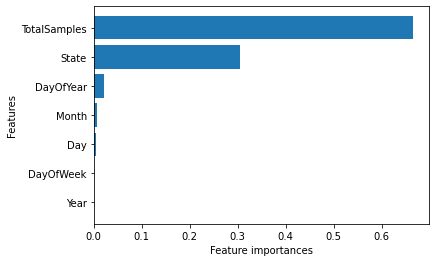

In [122]:
plot_features(X_train.columns, ideal_model.feature_importances_) 

In [123]:
import pickle
# open a file, where you want to store data
file = open ('random_forest_regression.pkl','wb')
pickle.dump(ideal_model,file)